In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import os
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf

import tensorflow as tf
import cv2
import numpy
import gc
import keras

import matplotlib.pyplot as plt

import tensorflow as tf
import math

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math
tfkc = tfk.callbacks

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class ImageSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_folder, batch_size, image_size, augmentations=None):
        """
        Args:
            base_folder (str): Path to the base folder containing subfolders with images and masks.
            batch_size (int): Number of samples per batch.
            image_size (tuple): Target size for resizing images (height, width).
            augmentations (callable): Optional augmentation function for images and masks.
        """
        self.base_folder = base_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentations = augmentations
        self.image_paths, self.mask_paths = self._load_paths()
        self.on_epoch_end()

    def _load_paths(self):
        """
        Traverse the base folder and collect paths for images and masks.
        Returns:
            list: List of image paths.
            list: List of mask paths.
        """
        image_paths = []
        mask_paths = []

        subfolders = [folder for folder in os.listdir(self.base_folder) if os.path.isdir(os.path.join(self.base_folder, folder))]

        for subfolder in subfolders:
            images_folder = os.path.join(self.base_folder, subfolder, 'images')
            masks_folder = os.path.join(self.base_folder, subfolder, 'ground_truth')

            # Collect sorted file lists to ensure images and masks align
            image_files = sorted(os.listdir(images_folder))
            mask_files = sorted(os.listdir(masks_folder))

            for img_file, mask_file in zip(image_files, mask_files):
                image_paths.append(os.path.join(images_folder, img_file))
                mask_paths.append(os.path.join(masks_folder, mask_file))

        return image_paths, mask_paths

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_image_paths = self.image_paths[start_idx:end_idx]
        batch_mask_paths = self.mask_paths[start_idx:end_idx]

        # Load and preprocess images and masks
        images, masks = self._load_data(batch_image_paths, batch_mask_paths)

        return images, masks

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        temp = list(zip(self.image_paths, self.mask_paths))
        np.random.shuffle(temp)
        self.image_paths, self.mask_paths = zip(*temp)

    def _load_data(self, batch_image_paths, batch_mask_paths):
        images = []
        masks = []

        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            # Load image and mask
            img = load_img(img_path, target_size=self.image_size)
            mask = load_img(mask_path, target_size=self.image_size, color_mode='grayscale')

            # Convert to arrays
            img = img_to_array(img) #/ 255.0  # Normalize image

             # Maszk betöltése és binárissá alakítása
            mask = load_img(mask_path, target_size=self.image_size, color_mode='grayscale')
            mask = img_to_array(mask)
            mask = (mask > 0).astype(int)  # Binárissá alakítás: 0 vagy 1

            # Apply augmentations if provided
             #if self.augmentations:
               # augmented = self.augmentations(image=img, mask=mask)
               # img = augmented['image']
               # mask = augmented['mask']

            images.append(img)
            masks.append(mask)

        # Convert to numpy arrays
        return np.array(images), np.array(masks)

# Példa használat
base_folder = '/content/drive/MyDrive/szakdoga/Synthetic_MICCAI2020_dataset'
image_size = (538, 701)  # Képek átméretezése 128x128-ra
batch_size = 32

# Inicializálás a mappák automatikus bejárásával
generator = ImageSegmentationGenerator(base_folder, batch_size, image_size)


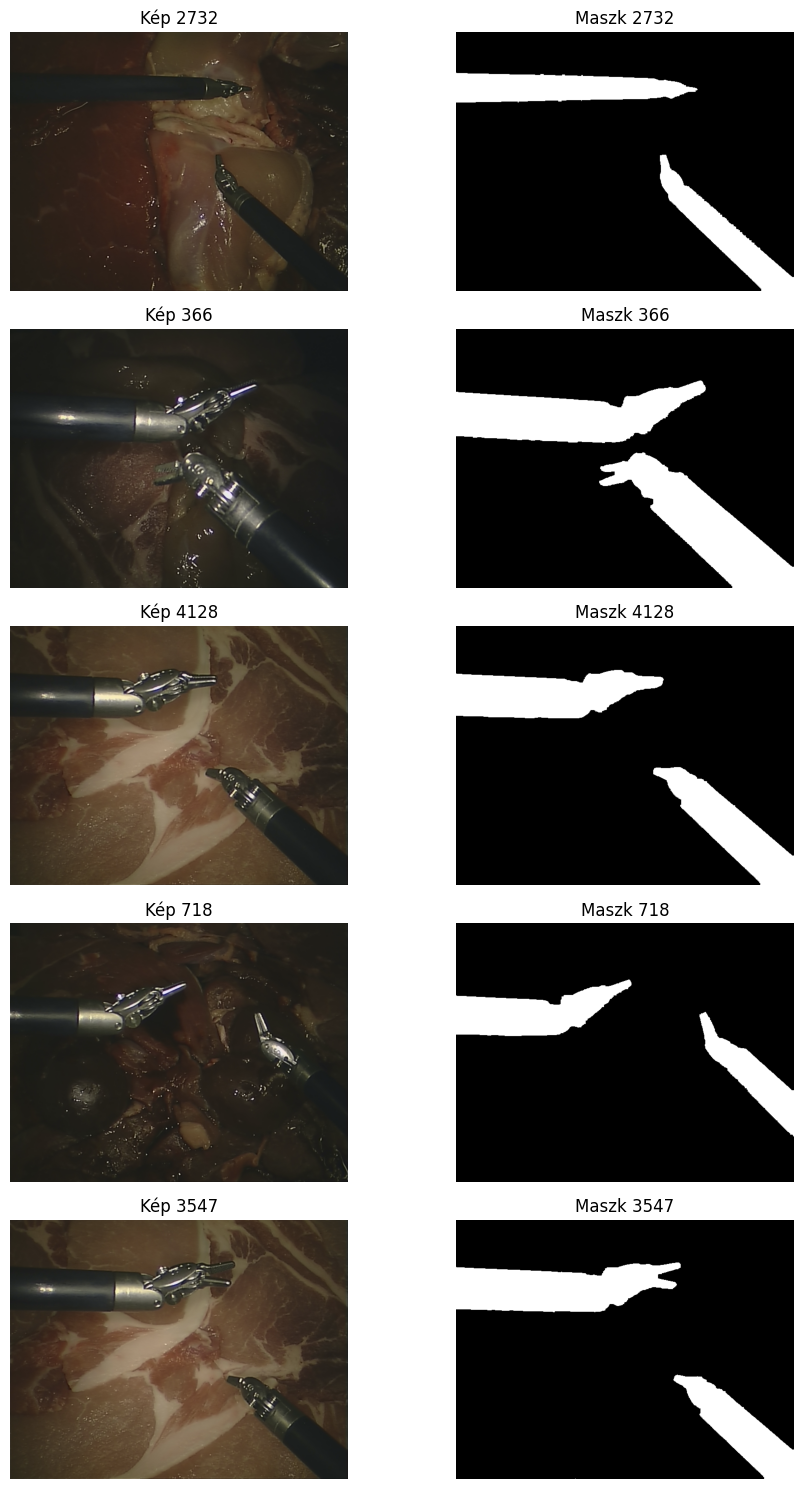

In [ ]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_random_images(generator, num_images=5):
    """
    Kirajzol véletlenszerű képeket és a hozzájuk tartozó maszkokat az adatgenerátorból.

    Args:
        generator (ImageSegmentationGenerator): Az adatgenerátor példánya.
        num_images (int): Hány képet szeretnénk kirajzolni.
    """
    # Ellenőrizzük, hogy elég képpel rendelkezünk-e
    if len(generator.image_paths) < num_images:
        raise ValueError("Nem elég kép a generátorban a megadott számú véletlenszerű kép kiválasztásához.")

    # Véletlenszerű indexek kiválasztása
    indices = random.sample(range(len(generator.image_paths)), num_images)

    # Képek és maszkok betöltése az indexek alapján
    images = []
    masks = []
    for idx in indices:
        img_path = generator.image_paths[idx]
        mask_path = generator.mask_paths[idx]

        img = load_img(img_path, target_size=generator.image_size)
        mask = load_img(mask_path, target_size=generator.image_size, color_mode='grayscale')

        images.append(img_to_array(img) / 255.0)  # Normalizált kép
        masks.append(img_to_array(mask) / 255.0)  # Normalizált maszk

    # Kirajzolás
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    for i in range(num_images):
        # Kép
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Kép {indices[i]}")

        # Maszk
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Maszk {indices[i]}")

    plt.tight_layout()
    plt.show()


# Véletlenszerű képek kirajzolása a generátorból
plot_random_images(generator, num_images=5)


In [ ]:
#uj spliteles

import numpy as np
from sklearn.model_selection import train_test_split

def split_data(images, masks, test_size=0.2):

    from sklearn.model_selection import train_test_split
    return train_test_split(images, masks, test_size=test_size)

    # Adatok betöltése a generátorból
    images = []
    masks = []

    for i in range(len(generator)):
        batch_images, batch_masks = generator[i]
        images.append(batch_images)
        masks.append(batch_masks)

    # Összefűzzük a batch-eket egyetlen tömbbé
    images = np.concatenate(images, axis=0)
    masks = np.concatenate(masks, axis=0)

    # Az extra dimenzió eltávolítása a maszkokról
    masks = np.squeeze(masks, axis=-1)

    print(f"Beolvasott képek mérete: {images.shape}")
    print(f"Beolvasott maszkok mérete: {masks.shape}")

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(
        images, masks, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, Y_train, Y_test

# Splitelés meghívása
#X_train, X_test, Y_train, Y_test = split_data(generator, test_size=0.2)
#print("Adathalmaz felosztva:")
#print(f"X_train mérete: {X_train.shape}, Y_train mérete: {Y_train.shape}")
#print(f"X_test mérete: {X_test.shape}, Y_test mérete: {Y_test.shape}")


In [ ]:
#kepek mentese

def save_images(X_train, X_test, output_path):
    """
    Elmenti a képeket .npy formátumba.

    Args:
        X_train, X_test (np.array): A felosztott képek.
        output_path (str): Az elérési út, ahova a fájlokat mentjük.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for split_name, data in zip(["X_train", "X_test"], [X_train, X_test]):
        print(f"Képek mentése: {split_name}")
        file_path = os.path.join(output_path, f"{split_name}.npy")
        np.save(file_path, data)
        print(f"{split_name} mentve: {file_path}")

        # GC hívása az aktuális ciklus után
        del data
        gc.collect()

    # GC hívása az egész függvény végén
    gc.collect()


In [ ]:
#maszkok one hot encodeolasa es mentese

import os
import gc  # Garbage Collector importálása

def encode_and_save_masks(Y_train, Y_test, output_path, num_classes=2):
    """
    One-hot encodeolja a maszkokat és elmenti azokat.

    Args:
        Y_train, Y_test (np.array): A felosztott maszkok.
        output_path (str): Az elérési út, ahova a fájlokat mentjük.
        num_classes (int): Az osztályok száma.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # One-hot encode a maszkokon
    for split_name, data in zip(["Y_train", "Y_test"], [Y_train, Y_test]):
        print(f"One-hot encode fut: {split_name}")
        data = np.eye(num_classes)[data.astype(int)]  # One-hot encode
        data = data.reshape(data.shape[:-1] + (num_classes,))  # Alakítjuk

        # Mentés
        file_path = os.path.join(output_path, f"{split_name}.npy")
        np.save(file_path, data)
        print(f"{split_name} mentve: {file_path}")

        # GC hívása az aktuális ciklus után
        del data
        gc.collect()

    # GC hívása az egész függvény végén
    gc.collect()


In [ ]:
# Egy batch betöltése a generátorból
batch_images, batch_masks = generator[0]

# Alapvető információk kiírása
print(f"Batch képek alakja: {batch_images.shape}")
print(f"Batch maszkok alakja: {batch_masks.shape}")
print(f"Batch maszk minimum értéke: {np.min(batch_masks)}")
print(f"Batch maszk maximum értéke: {np.max(batch_masks)}")


Batch képek alakja: (32, 538, 701, 3)
Batch maszkok alakja: (32, 538, 701, 1)
Batch maszk minimum értéke: 0
Batch maszk maximum értéke: 1


In [ ]:
import gc
import numpy as np
import glob
import os

# Output fájlok elérési útja
images_output_path = "/content/drive/MyDrive/szakdoga"
train_images_file = f"{images_output_path}/train_images.npy"
test_images_file = f"{images_output_path}/test_images.npy"
train_masks_file = f"{images_output_path}/train_masks.npy"
test_masks_file = f"{images_output_path}/test_masks.npy"

# Batch-ek külön fájlokba mentése
for i in range(len(generator)):
    batch_images, batch_masks = generator[i]
    batch_masks = np.squeeze(batch_masks, axis=-1)
    batch_masks_one_hot = np.eye(2, dtype=np.uint8)[batch_masks.astype(int)]

    # 80-20 felosztás
    split_idx = int(0.8 * len(batch_images))
    train_images_batch = batch_images[:split_idx]
    test_images_batch = batch_images[split_idx:]
    train_masks_batch = batch_masks_one_hot[:split_idx]
    test_masks_batch = batch_masks_one_hot[split_idx:]

    # Batch-ek külön fájlokba mentése
    np.save(f"{images_output_path}/train_images_batch_{i}.npy", train_images_batch)
    np.save(f"{images_output_path}/test_images_batch_{i}.npy", test_images_batch)
    np.save(f"{images_output_path}/train_masks_batch_{i}.npy", train_masks_batch)
    np.save(f"{images_output_path}/test_masks_batch_{i}.npy", test_masks_batch)

    print(f"Batch {i} mentve.")

    # Memória felszabadítása
    del batch_images, batch_masks, batch_masks_one_hot, train_images_batch, test_images_batch, train_masks_batch, test_masks_batch
    gc.collect()




Batch 0 mentve.
Batch 1 mentve.
Batch 2 mentve.
Batch 3 mentve.
Batch 4 mentve.
Batch 5 mentve.
Batch 6 mentve.
Batch 7 mentve.
Batch 8 mentve.
Batch 9 mentve.
Batch 10 mentve.
Batch 11 mentve.
Batch 12 mentve.
Batch 13 mentve.
Batch 14 mentve.
Batch 15 mentve.
Batch 16 mentve.
Batch 17 mentve.
Batch 18 mentve.
Batch 19 mentve.
Batch 20 mentve.
Batch 21 mentve.
Batch 22 mentve.
Batch 23 mentve.
Batch 24 mentve.
Batch 25 mentve.
Batch 26 mentve.
Batch 27 mentve.
Batch 28 mentve.
Batch 29 mentve.
Batch 30 mentve.
Batch 31 mentve.
Batch 32 mentve.
Batch 33 mentve.
Batch 34 mentve.
Batch 35 mentve.
Batch 36 mentve.
Batch 37 mentve.
Batch 38 mentve.
Batch 39 mentve.
Batch 40 mentve.
Batch 41 mentve.
Batch 42 mentve.
Batch 43 mentve.
Batch 44 mentve.
Batch 45 mentve.
Batch 46 mentve.
Batch 47 mentve.
Batch 48 mentve.
Batch 49 mentve.
Batch 50 mentve.
Batch 51 mentve.
Batch 52 mentve.
Batch 53 mentve.
Batch 54 mentve.
Batch 55 mentve.
Batch 56 mentve.
Batch 57 mentve.
Batch 58 mentve.
Batch 5

OSError: [Errno 107] Transport endpoint is not connected

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Resizing
import tensorflow as tf

def unet(input_size=(538, 701, 3), resize_to=(256, 256)):
    """
    U-Net modell, amely átméretezi a bemeneti képeket az első réteg előtt,
    és visszaméretezi az utolsó réteg után az eredeti méretre.
    """
    inputs = Input(input_size)

    # Átméretezés a feldolgozáshoz (pl. 256x256)
    resized_inputs = Resizing(*resize_to)(inputs)

    # Encoder rész
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(resized_inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Middle rész
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder rész
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    # Utolsó réteg: kimeneti osztályok
    outputs = Conv2D(2, (1, 1), activation="softmax", padding="same")(conv9)

    # Átméretezés vissza az eredeti méretre
    resized_outputs = Resizing(input_size[0], input_size[1])(outputs)

    # Modell összeállítása
    model = tf.keras.Model(inputs=inputs, outputs=resized_outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Modell összeállítása
model = unet()

# Modell összefoglaló
#model.summary()


In [ ]:
import glob

def data_generator_multiple_files(image_pattern, mask_pattern, batch_size):
    """
    Generátor több batch fájlból történő betöltéshez.

    Args:
        image_pattern (str): A képfájlok mintája (pl. 'train_images_batch_*.npy').
        mask_pattern (str): A maszkfájlok mintája (pl. 'train_masks_batch_*.npy').
        batch_size (int): A batch méret.

    Yields:
        tuple: (képek batch, maszkok batch)
    """
    # Batch fájlok betöltése sorrendben
    image_files = sorted(glob.glob(image_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    mask_files = sorted(glob.glob(mask_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    if len(image_files) != len(mask_files):
        raise ValueError("A képfájlok és maszkfájlok száma nem egyezik meg.")

    while True:  # Végtelen generátor
        for image_file, mask_file in zip(image_files, mask_files):
            # Fájlok betöltése
            images = np.load(image_file, allow_pickle=False)
            masks = np.load(mask_file, allow_pickle=False)

            # Batch-ekre bontás
            for i in range(0, len(images), batch_size):
                image_batch = images[i:i + batch_size]
                mask_batch = masks[i:i + batch_size]
                yield image_batch, mask_batch


In [ ]:
# Adatfájlok mintázata
train_images_pattern = "/content/drive/MyDrive/szakdoga/train_images_batch_*.npy"
train_masks_pattern = "/content/drive/MyDrive/szakdoga/train_masks_batch_*.npy"
test_images_pattern = "/content/drive/MyDrive/szakdoga/test_images_batch_*.npy"
test_masks_pattern = "/content/drive/MyDrive/szakdoga/test_masks_batch_*.npy"

# Adatgenerátorok inicializálása
train_gen = data_generator_multiple_files(train_images_pattern, train_masks_pattern, batch_size=16)
test_gen = data_generator_multiple_files(test_images_pattern, test_masks_pattern, batch_size=16)

# Train és validation adatok méretének statikus meghatározása
train_size = 3264  # Az összes train adat száma
val_size = 800     # Az összes validation adat száma

# Train és validation adatok méretének meghatározása
#train_size = sum(len(np.load(f, allow_pickle=False)) for f in glob.glob(train_images_pattern))
#val_size = sum(len(np.load(f, allow_pickle=False)) for f in glob.glob(test_images_pattern))


In [ ]:
#meglassuk
from tensorflow.keras.models import load_model  # load_model importálása
# A legjobb modell betöltése
best_model = load_model('/content/drive/MyDrive/szakdoga/best_model.keras')

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/szakdoga/best_model.keras",  # Ez határozza meg az elérési utat és fájlnevet
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min"
)

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback inicializálása
early_stopping = EarlyStopping(
    monitor='val_loss',  # Mit figyeljünk (pl. validation loss)
    patience=5,          # Hány epoch után álljon meg, ha nincs javulás
    restore_best_weights=True  # Állítsa vissza a legjobb súlyokat
)

In [ ]:
# Tanítás
history = model.fit(
    train_gen,
    steps_per_epoch=train_size // 32,  # Batch-ek száma epochonként
    validation_data=test_gen,
    validation_steps=val_size // 32,  # Validation batch-ek száma
    epochs=100,  # Maximum epochok száma
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9153 - loss: 0.2555
Epoch 1: val_loss improved from inf to 0.03428, saving model to /content/drive/MyDrive/szakdoga/best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9157 - loss: 0.2543 - val_accuracy: 0.9868 - val_loss: 0.0343
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9888 - loss: 0.0291
Epoch 2: val_loss improved from 0.03428 to 0.01948, saving model to /content/drive/MyDrive/szakdoga/best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9888 - loss: 0.0290 - val_accuracy: 0.9923 - val_loss: 0.0195
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9922 - loss: 0.0195
Epoch 3: val_loss improved from 0.01948 to 0.01506, saving model to /content/drive/MyDrive/szakdoga/best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9922 - loss: 0.0195 - val_accuracy: 0.9940 - val_loss: 0.0151
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np

# Definiáljuk a metrikákat (IoU, Dice, Precision, Recall, MAE, MSE)
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

def precision_score(y_true, y_pred):
    true_positive = np.sum((y_pred == 1) & (y_true == 1))
    false_positive = np.sum((y_pred == 1) & (y_true == 0))
    precision = true_positive / (true_positive + false_positive)
    return precision

def recall_score(y_true, y_pred):
    true_positive = np.sum((y_pred == 1) & (y_true == 1))
    false_negative = np.sum((y_pred == 0) & (y_true == 1))
    recall = true_positive / (true_positive + false_negative)
    return recall

def mean_absolute_error(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


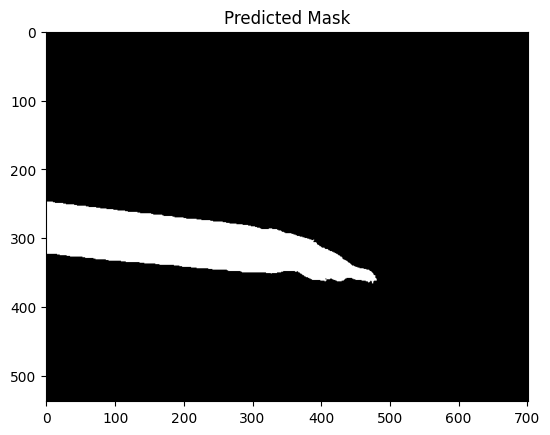

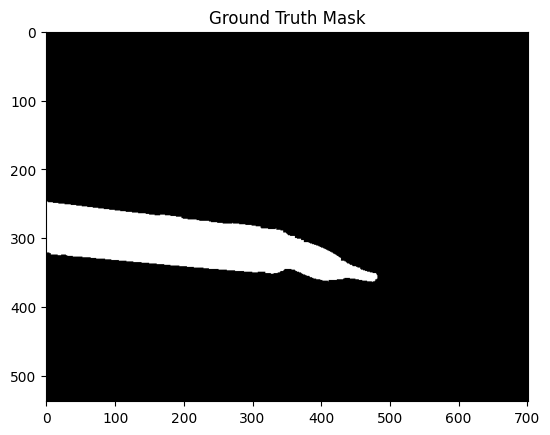

IoU Score: 0.9654861343133979
Dice Coefficient: 0.9824400360378738


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
import glob

# A legjobb modell betöltése
best_model = load_model('/content/drive/MyDrive/szakdoga/best_model.keras')

# Batch fájlok mintája
test_images_pattern = "/content/drive/MyDrive/szakdoga/test_images_batch_*.npy"
test_masks_pattern = "/content/drive/MyDrive/szakdoga/test_masks_batch_*.npy"

# Összes batch fájl száma
test_image_files = sorted(glob.glob(test_images_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))
test_mask_files = sorted(glob.glob(test_masks_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

total_batches = len(test_image_files)

# Véletlenszerű batch fájl kiválasztása
random_batch_index = random.randint(0, total_batches - 1)
random_image_file = f"/content/drive/MyDrive/szakdoga/test_images_batch_{random_batch_index}.npy"
random_mask_file = f"/content/drive/MyDrive/szakdoga/test_masks_batch_{random_batch_index}.npy"

# Batch fájlok betöltése
test_images = np.load(random_image_file)
test_masks = np.load(random_mask_file)

# Véletlenszerű kép kiválasztása a batch-ből
random_image_index = random.randint(0, len(test_images) - 1)
selected_image = test_images[random_image_index:random_image_index + 1]  # Batch formátumban a modellhez
selected_mask = test_masks[random_image_index]  # Eredeti maszk

# Előrejelzés az adott képre
predictions = best_model.predict(selected_image)  # Egyetlen mintát küldünk a modellnek
predicted_mask = np.argmax(predictions[0], axis=-1)  # Argmax az osztályokra

# Megjelenítés az előrejelzett maszkról
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

# A valós maszk egycsatornás formára konvertálása
ground_truth_mask = np.argmax(selected_mask, axis=-1)

# Megjelenítés a valósághű maszkról
plt.figure()
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.show()

# Metrikák számítása
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

print("IoU Score:", iou_score(ground_truth_mask, predicted_mask))
print("Dice Coefficient:", dice_coefficient(ground_truth_mask, predicted_mask))


In [ ]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#baszodas mer nemtudom

%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.image import resize
import matplotlib.pyplot as plt
from PIL import Image

# Modell betöltése
@st.cache_resource
def load_trained_model():
    model_path = "/content/drive/MyDrive/szakdoga/best_model.keras"
    model = load_model(model_path)
    return model

model = load_trained_model()

# Streamlit alkalmazás címe
st.title("Képszegmentáló Webalkalmazás!!!")
st.write("Tölts fel egy képet, és a modell elvégzi a szegmentációt!")

# Kép feltöltése
uploaded_file = st.file_uploader("Válassz egy képet", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # 1. Feltöltött kép betöltése
    image = Image.open(uploaded_file)
    st.image(image, caption="Feltöltött kép", use_column_width=True)
    st.write("A kép feldolgozása zajlik...")

    # 2. Eredeti méret mentése
    original_size = image.size  # (szélesség, magasság)
    st.write(f"Eredeti kép mérete: {original_size}")

    # 3. Kép átalakítása numpy tömbbé
    image = image.convert("RGB")  # RGB biztosítása
    image_array = np.array(image)

    # Debugging: Ellenőrizzük a kép alakját
    st.write(f"Kép alakja numpy tömbbé alakítás után: {image_array.shape}")

    # 4. Kép átméretezése a modellhez
    target_size = (538, 701)  # A modell által várt méret (magasság, szélesség)
    resized_image = resize(image_array, target_size)  # TensorFlow resize
    resized_image = resized_image / 255.0  # Normalizálás
    resized_image = np.expand_dims(resized_image, axis=0)  # Batch dimenzió hozzáadása

    # Debugging: Ellenőrizzük a bemeneti adatokat
    st.write(f"Átméretezett kép alakja (modellhez): {resized_image.shape}")
    st.write(f"Átméretezett kép értékek: min={resized_image.min()}, max={resized_image.max()}")

    # 5. Modell predikció
    predicted_mask = model.predict(resized_image)

    # Debugging: Ellenőrizzük a modell kimenetét
    st.write(f"Modell kimenet alakja: {predicted_mask.shape}")
    st.write(f"Modell kimenet egyedi értékei (raw output): {np.unique(predicted_mask)}")

    # 6. Maszk készítése
    predicted_mask = np.argmax(predicted_mask[0], axis=-1)  # Osztálymaszk
    st.write(f"Maszk egyedi értékei (np.argmax után): {np.unique(predicted_mask)}")
    st.write(f"Predicted mask shape before resize: {predicted_mask.shape}")

    # 7. Maszk visszaalakítása eredeti méretre
    # A TensorFlow `resize` 3 vagy 4 dimenziót vár, ezért bővítsük ki
    predicted_mask = np.expand_dims(predicted_mask, axis=-1)  # Csatorna dimenzió hozzáadása
    st.write(f"Maszk dimenziók bővítése után: {predicted_mask.shape}")

    resized_mask = resize(predicted_mask, (original_size[1], original_size[0]), method="nearest").numpy()
    resized_mask = np.squeeze(resized_mask, axis=-1).astype(np.uint8)  # Visszaalakítás 2D formára

    # Debugging: Ellenőrizzük az átméretezett maszkot
    st.write(f"Resized mask shape: {resized_mask.shape}")
    st.write(f"Resized mask értékek: min={resized_mask.min()}, max={resized_mask.max()}")

    # 8. Maszk megjelenítése
    st.write("Szegmentáció eredménye (eredeti méret):")
    fig, ax = plt.subplots()
    ax.imshow(resized_mask, cmap="gray")
    ax.axis("off")
    st.pyplot(fig)


Writing app.py


In [ ]:
#nem atmeretezos

%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.image import resize
import matplotlib.pyplot as plt
from PIL import Image



# Modell betöltése
@st.cache_resource
def load_trained_model():
    model_path = "/content/drive/MyDrive/szakdoga/best_model.keras"  # Add meg a saját modell elérési útját
    model = load_model(model_path)
    return model

model = load_trained_model()

# Streamlit alkalmazás címe
st.title("Képszegmentáló Webalkalmazás")
st.write("Tölts fel egy képet, és a modell elvégzi a szegmentációt!")

# Kép feltöltése
uploaded_file = st.file_uploader("Válassz egy képet", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Feltöltött kép megjelenítése
    image = Image.open(uploaded_file)
    st.image(image, caption="Feltöltött kép", use_column_width=True)
    st.write("A kép feldolgozása zajlik...")

    # Kép előkészítése a modellhez
    image_array = np.array(image)
    input_shape = model.input_shape[1:3]  # Modell elvárt bemeneti mérete
    resized_image = resize(image_array, input_shape)  # Átméretezés az elvárt méretre
    resized_image = np.expand_dims(resized_image, axis=0)  # Batch dimenzió hozzáadása

    # Szegmentáció futtatása
    predicted_mask = model.predict(resized_image)
    predicted_mask = np.argmax(predicted_mask[0], axis=-1)  # Osztálymaszk

    # Szegmentációs eredmény megjelenítése
    st.write("Szegmentáció eredménye:")
    fig, ax = plt.subplots()
    ax.imshow(predicted_mask, cmap="gray")
    ax.axis("off")
    st.pyplot(fig)


Overwriting app.py


In [ ]:
#proba
!pip install --upgrade google-colab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.3 MB/s eta 0:00:00


In [ ]:
!ngrok authtoken 2QqRniu0gBm6NqLIOZOPobUrQSk_6MR9jYBFsYK3jC1SXhNnW

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Minden alagút bezárása
ngrok.kill()


In [ ]:
import subprocess
from pyngrok import ngrok

#ngrok.kill()

# Streamlit alkalmazás futtatása
process = subprocess.Popen(['streamlit', 'run', 'app.py', '--server.port', '8501'])

# Ngrok alagút létrehozása
public_url = ngrok.connect("http://localhost:8501")
print(f"Nyilvános URL: {public_url}")

Nyilvános URL: NgrokTunnel: "https://dce1-34-125-117-37.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!ls

app.py	drive  sample_data
